In [67]:
import numpy as np
from pathlib import Path
import struct#用于数据类型的转换 bytes to str
import matplotlib.pyplot as plt

In [65]:
def Read_img_File(filepath):
    with open(filepath,'rb') as f:
        struct.unpack('>4i',f.read(16))#4i代表4位整型，int：占4字节，4*8=32bit
        data=np.fromfile(f,dtype=np.uint8)
        return data.reshape(-1,28*28)
    
def Read_label_File(filepath):
    with open(filepath,'rb') as f:
        struct.unpack('>2i',f.read(8))
        data=np.fromfile(f,dtype=np.uint8)
        return data
def loadDataSets():
    train_img_path='handwrite/train-images.idx3-ubyte'
    train_label_path='handwrite/train-labels.idx1-ubyte'
    test_img_path='handwrite/t10k-images.idx3-ubyte'
    test_label_path='handwrite/t10k-labels.idx1-ubyte'
    train_img=Read_img_File(train_img_path)
    train_label=Read_label_File(train_label_path)
    test_img=Read_img_File(test_img_path)
    test_label=Read_label_File(test_label_path)
    return train_img,train_label,test_img,test_label
train_img,train_label,test_img,test_label=loadDataSets()


[array([[ 0.06674321,  0.07828892,  0.07572998, ...,  0.04497892,
         0.07166848,  0.0783158 ],
       [-0.07550147, -0.05650199,  0.06004355, ..., -0.02064747,
        -0.03207563,  0.06148705],
       [-0.0790739 ,  0.00989914, -0.06532536, ...,  0.08375338,
         0.0337417 ,  0.01315227],
       ...,
       [ 0.0554073 ,  0.07847227, -0.067351  , ..., -0.04369898,
         0.05008107,  0.00367608],
       [-0.0128868 ,  0.04019596, -0.06821346, ...,  0.08667118,
        -0.02495646,  0.06625986],
       [ 0.00790279, -0.05273737,  0.01332947, ...,  0.05559472,
        -0.02768894, -0.02379504]]), array([[-0.07778807,  0.01918983,  0.03175096, ...,  0.0383643 ,
         0.00635742,  0.02636519],
       [ 0.07594674,  0.0298443 , -0.0211606 , ..., -0.05046697,
         0.04256121,  0.03972094],
       [ 0.0579682 , -0.08268225, -0.01268508, ..., -0.03626317,
         0.00554059, -0.03267976],
       ...,
       [ 0.08357975,  0.07266462,  0.07081462, ..., -0.06182843,
        

label: 5


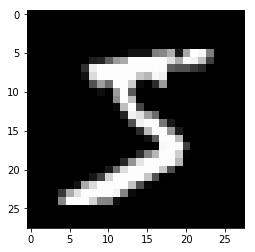

In [3]:
def show_img(img):
    plt.imshow(img.reshape(28,28),cmap='gray')
show_img(train_img[0])
print('label:',train_label[0])

In [4]:
print(train_img.shape,train_label.shape)

(60000, 784) (60000,)


In [66]:
#确定各层的激活项的个数
#输入层：784个，隐藏层数1：784个，输出层1：10个
layer_activity_num=[28*28,28*28,10]

#激活函数
def sigmoid(z):
    return 1/(1+np.exp(-z))
#激活函数导数
def d_sigmoid(z):
    s=sigmoid(z)
    return s*(1-s)
#初始化权重矩阵
def theta_init():
    theta=[]
    for i in range(len(layer_activity_num)-1):
        m=layer_activity_num[0]+layer_activity_num[-1]
        theta_temp=np.random.uniform(-np.sqrt(6/m),np.sqrt(6/m),size=(layer_activity_num[i+1],layer_activity_num[i]+1))
        theta.append(theta_temp)
    return theta




In [11]:
import time
#训练数量
test_num=1000
#
#输入值X
X=train_img[:test_num,:]
#标签对应的向量Y
Y_label=train_label[:test_num]
Y_exa=np.identity(10)
Y=Y_exa[Y_label[0]].reshape(-1,1)
for i in range(1,Y_label.shape[0]):
    Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])

print(X.shape)


(1000, 784)


In [12]:
#正向传播
def ForwardPropagation(X,theta):
    a=X.T #某层的激活项
    activity=[]#记录所有层的激活项
    activity.append(a)
    for i in range(len(layer_activity_num)-1):
        a=np.vstack([np.ones((1,a.shape[1])),a])#添加偏置单元
        Z=theta[i].dot(a)#矩阵相乘得到Z
        a=sigmoid(Z)#计算下一层激活项a
        activity.append(a)
    return activity

In [50]:
#前向传播获取各个部分的激活项
activity=ForwardPropagation(X,theta)
Y_predict=activity[-1]


In [52]:
#计算代价
def cost_function(theta,Y_predict,Y,Lamaba):
    m=X.shape[0]
    part1=-(Y*np.log(Y_predict)+(1-Y)*np.log(1-Y_predict)).sum()/m
    part2=0
    for i in range(len(theta)):
        part2+=((np.delete(theta[i],0,axis=1)**2).sum()*Lamaba)/(2*m)
    J=part1+part2
    return J
lamada=1
cost_function(theta,Y_predict,Y,lamada)

8.457207491877108

(784, 1000)


In [62]:
#反向传播,小批量梯度下降
#计算出所有的偏导数
def Backpropagation(activity,theta,Y_predict,Y,lamada):
    #1.计算误差项
    err_list=[]
    d_theta_list=[]
    err=Y_predict-Y #输出层的误差
    err_list.append(err)
    ix=len(theta)-1 #2-1=1
    count_i=0
    while ix>=0:
        theta_temp=np.delete(theta[ix],0,axis=1)
        #计算前一层的误差
        err=theta_temp.T.dot(err)*d_sigmoid(activity[ix])
        err_list.insert(0,err)
    #2.求各个theta的偏导
        #给每一列激活项添加偏置项
        activity_temp=np.vstack([np.ones((1,activity[ix].shape[1])),activity[ix]]).T
        #用于更新偏导的theta临时变量，加上一层偏置项0
        theta_temp=np.hstack([np.zeros((theta_temp.shape[0],1)),theta_temp])
        #取前一层误差
        err_temp=err_list[1]
        #用于所有偏导阵相加的零阵
        d_theta=np.zeros((theta[ix].shape[0],theta[ix].shape[1]))
        m=activity_temp.shape[0]
        #m：样本数
        for act_ix in range(m):   
            #某一个样本的偏导矩阵
            d_theta_temp=err_temp[:,act_ix].reshape(-1,1)*activity_temp[act_ix]
            d_theta+=d_theta_temp #每一个样本计算的偏导矩阵叠加
            d_theta=d_theta/m+theta_temp*(lamada/m)#计算该层所有的偏导
        #得到一个偏导叠加的矩阵
        d_theta_list.insert(0,d_theta)
        ix-=1
    return d_theta_list
d_theta=Backpropagation(activity,theta,Y_predict,Y,lamada)
#print(d_theta,d_theta[0].shape,d_theta[1].shape)

G:\WorkProgram\anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [ ]:
def train():
    #测试数量
    test_num=20000
    #每一批的数量
    batch_num=200
    
    #输入值X
    X=train_img[:test_num,:]
    #标签对应的向量Y
    Y_label=train_label[:test_num]
    Y_exa=np.identity(10)
    Y=Y_exa[Y_label[0]].reshape(-1,1)
    for i in range(1,Y_label.shape[0]):
        Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])
    
    theta=init

In [53]:
#反向传播
#计算出所有的偏导数
def Backpropagation1(activity,theta,Y_predict,Y,lamada):
    #1.计算误差项
    err_list=[]
    d_theta_list=[]
    
    err=Y_predict-Y #输出层的误差
    err_list.append(err)
    ix=len(theta)-1
    count_i=0
    while ix>=0:

        theta_temp=np.delete(theta[ix],0,axis=1)
        #print(theta_temp.shape,theta[ix].shape)
        #(10, 784) (10, 785)
        err=theta_temp.T.dot(err)*d_sigmoid(activity[ix])
        err_list.insert(0,err)
    #2.求各个theta的偏导
        d_theta_i=np.zeros((theta[ix].shape[0],theta[ix].shape[1]))
        #给每一列激活项添加偏置项
        activity_temp=np.vstack([np.ones((1,activity[ix].shape[1])),activity[ix]]).T
        
        theta_temp=np.hstack([np.zeros((theta_temp.shape[0],1)),theta_temp])
        #print(theta_temp)
        #print(theta_temp.shape)#(10, 785)
        err_temp=err_list[1].T
        #print(err_list[1].shape)
        #(10000,10)
        #print(activity_temp.shape)
        #(10000,785)
        
        #用于所有偏导阵相加的零阵
        d_theta=np.zeros((theta[ix].shape[0],theta[ix].shape[1]))
        m=activity_temp.shape[0]
        
        for act_ix in range(m):
            
            d_theta_temp=[]
            for er in err_temp[act_ix]:
                d_theta_temp.append(activity_temp[act_ix]*er)
                
            d_theta_temp=np.array(d_theta_temp)#某一个样本的偏导矩阵
            d_theta+=d_theta_temp #偏导叠加
            d_theta=d_theta/m+theta_temp*(lamada/m)

 
        #得到一个偏导叠加的矩阵    
        d_theta_list.insert(0,d_theta)
        ix-=1
    return d_theta_list
                       

#d_theta=Backpropagation(activity,theta,Y_predict,Y,lamada)
#print(d_theta,d_theta[0].shape,d_theta[1].shape)

In [25]:
print(len(theta),len(d_theta))

2 2


In [45]:
def grad1(theta,d_theta):
    alpha=0.01
    theta1=[]
    for theta_temp,d_theta_temp in zip(theta,d_theta):
        theta1.append(theta_temp-alpha*d_theta_temp)
    #预测
    testnum=100
    X=test_img[:testnum,:]
    #标签对应的向量Y
    Y_label=test_label[:testnum]
    Y_exa=np.identity(10)
    Y=Y_exa[Y_label[0]].reshape(-1,1)
    for i in range(1,Y_label.shape[0]):
        Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])
        
    y=ForwardPropagation(X,theta1)[-1]
    y_t=[np.argmax(y_i) for y_i in y.T]
    print(cost_function(theta1,y,Y,1))
    print(y_t)
    print(Y_label)

grad1(theta,d_theta)
        

0.1587347015681188
[0, 6, 0, 8, 7, 3, 0, 0, 9, 0, 0, 9, 0, 0, 9, 3, 0, 0, 0, 0, 6, 9, 0, 0, 7, 0, 0, 0, 0, 9, 3, 0, 0, 9, 0, 0, 0, 0, 9, 3, 6, 0, 9, 2, 3, 0, 0, 1, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 6, 0, 1, 9, 0, 3, 9, 9, 0, 0, 6, 2, 0, 3, 7, 1, 6, 1, 9, 6, 1, 0, 0, 6, 0, 9, 6, 3, 0, 2, 3, 0, 0, 0, 0, 0, 0]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]


In [60]:

#训练数量
test_num=10000
#每轮的数量
each_num=200

# #输入值X
# X=train_img[:test_num,:]
# #标签对应的向量Y
# Y_label=train_label[:test_num]
# Y_exa=np.identity(10)
# Y=Y_exa[Y_label[0]].reshape(-1,1)
# for i in range(1,Y_label.shape[0]):
#     Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])

def train(X,Y,theta):
    alpha=0.01
    lamada=1
    X_c=X
    Y_c=Y
    for j in range(int(test_num/each_num)):
        f=j*each_num
        l=(j+1)*each_num
        X=X_c[f:l,:]
        Y=Y_c[:,f:l]
        print(X.shape,Y.shape)
        activity=ForwardPropagation(X,theta)
        Y_predict=activity[-1]
        d_theta=Backpropagation(activity,theta,Y_predict,Y,lamada)
        for i in range(len(theta)):
            theta[i]=theta[i]-alpha*d_theta[i]
        print('cost:',cost_function(theta,Y_predict,Y,lamada))
    return theta
ta=train(X,Y,theta)


(200, 784) (10, 200)


G:\WorkProgram\anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


cost: 0.03742127876257231
(200, 784) (10, 200)
cost: 0.03687490246976152
(200, 784) (10, 200)
cost: 0.037282891885546496
(200, 784) (10, 200)
cost: 0.037434931482937125
(200, 784) (10, 200)
cost: 0.03704896171871558
(200, 784) (10, 200)
cost: 0.03733339164443808
(200, 784) (10, 200)
cost: 0.03703828815300421
(200, 784) (10, 200)
cost: 0.03687984697545742
(200, 784) (10, 200)
cost: 0.03675771789018345
(200, 784) (10, 200)
cost: 0.03711953552391932
(200, 784) (10, 200)
cost: 0.03692558488701825
(200, 784) (10, 200)
cost: 0.03680733936553962
(200, 784) (10, 200)
cost: 0.036776724969230457
(200, 784) (10, 200)
cost: 0.03693150027597981
(200, 784) (10, 200)
cost: 0.036715098616239505
(200, 784) (10, 200)
cost: 0.037070954284740325
(200, 784) (10, 200)
cost: 0.03649609255255627
(200, 784) (10, 200)
cost: 0.03665105076595451
(200, 784) (10, 200)
cost: 0.03686711310988979
(200, 784) (10, 200)


KeyboardInterrupt: 

In [61]:
def predict(theta1):
    #预测
    testnum=100
    X=test_img[:testnum,:]
    #标签对应的向量Y
    Y_label=test_label[:testnum]
    Y_exa=np.identity(10)
    Y=Y_exa[Y_label[0]].reshape(-1,1)
    
    for i in range(1,Y_label.shape[0]):
        Y=np.hstack([Y,Y_exa[Y_label[i]].reshape(-1,1)])

    y=ForwardPropagation(X,theta1)[-1]
    y_t=[np.argmax(y_i) for y_i in y.T]
    print(cost_function(theta1,y,Y,1))
    print(y_t)
    print(Y_label)
predict(theta) 

0.028102148463253117
[7, 5, 6, 2, 7, 3, 2, 4, 5, 8, 7, 9, 5, 7, 2, 3, 7, 9, 1, 1, 2, 9, 7, 2, 1, 5, 2, 5, 7, 1, 3, 3, 3, 1, 2, 0, 7, 8, 9, 3, 6, 8, 9, 2, 3, 4, 3, 2, 7, 7, 2, 1, 5, 0, 9, 2, 5, 2, 5, 4, 1, 6, 7, 2, 5, 1, 9, 9, 3, 5, 9, 7, 6, 6, 8, 9, 3, 7, 2, 6, 1, 5, 5, 1, 2, 5, 5, 0, 9, 6, 3, 3, 2, 3, 6, 5, 3, 2, 9, 5]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]


In [ ]:
print(d_theta[0].shape,d_theta[1].shape)


In [ ]:
def checkgrad(theta,epsilon):
    for ix in range(len(theta)):
        theta_plus=theta.copy()
        theta_plus[ix]=theta_plus[ix]+epsilon
        theta_mins=theta.copy()
        theta_mins[ix]=theta_mins[ix]+epsilon
        J=(cost_function(theta_plus,Y_predict,Lamaba)-cost_function(theta_mins))/(2*epsilon)
        cost_function()

In [ ]:
a=[
    [
        [1,2],
        [3,4]
    ]
  ]
a=theta.copy()
print(a==b)




In [ ]:
list1 = ['Google', 'Runoob', 'Taobao']
list1.insert(1, 'Baidu')
print ('列表插入元素后为 : ', list1)
#list1 = ['Google', 'Runoob', 'Taobao']
list1.insert(0, 'Baidu')
print ('列表插入元素后为 : ', list1)
list1.insert(0, 'Baidu111')
print ('列表插入元素后为 : ', list1)
list1.insert(0, 'Baidu')
print ('列表插入元素后为 : ', list1)

In [ ]:
np.array([1])